In [3]:
!pip install gpxpy pandas matplotlib numpy seaborn folium

In [5]:
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
import glob
import seaborn as sns

# Set matplotlib to show plots inline
%matplotlib inline

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [7]:
class GPXAnalyzer:
    def __init__(self, gpx_folder_path):
        self.gpx_folder_path = gpx_folder_path
        self.workout_data = []
    
    def parse_gpx_file(self, file_path):
        """Parse single GPX file and extract workout data"""
        try:
            with open(file_path, 'r') as gpx_file:
                gpx = gpxpy.parse(gpx_file)
                
            for track in gpx.tracks:
                for segment in track.segments:
                    points = []
                    for point in segment.points:
                        points.append({
                            'latitude': point.latitude,
                            'longitude': point.longitude,
                            'elevation': point.elevation,
                            'time': point.time
                        })
                    
                    if points:
                        workout_info = self.calculate_workout_stats(points)
                        workout_info['file_name'] = os.path.basename(file_path)
                        workout_info['date'] = self.extract_date_from_filename(file_path)
                        self.workout_data.append(workout_info)
                        
        except Exception as e:
            print(f"❌ Error parsing {file_path}: {e}")
    
    def extract_date_from_filename(self, file_path):
        """Extract date from filename like route_2023-08-13_1.55am.gpx"""
        filename = os.path.basename(file_path)
        try:
            # Extract date part (e.g., "2023-08-13")
            date_part = filename.split('_')[1]
            return datetime.strptime(date_part, '%Y-%m-%d').date()
        except:
            return None
    
    def calculate_workout_stats(self, points):
        """Calculate workout statistics from GPS points"""
        if not points or len(points) < 2:
            return {}
            
        # Calculate total distance
        total_distance = 0
        for i in range(1, len(points)):
            total_distance += self.haversine_distance(
                points[i-1]['latitude'], points[i-1]['longitude'],
                points[i]['latitude'], points[i]['longitude']
            )
        
        # Calculate duration
        start_time = points[0]['time']
        end_time = points[-1]['time']
        duration = (end_time - start_time).total_seconds() / 60  # minutes
        
        # Calculate average speed
        avg_speed = (total_distance / duration) * 60 if duration > 0 else 0  # km/h
        
        # Elevation data
        elevations = [p['elevation'] for p in points if p['elevation'] is not None]
        elevation_gain = max(elevations) - min(elevations) if elevations else 0
        
        return {
            'total_distance_km': round(total_distance, 2),
            'duration_minutes': round(duration, 2),
            'avg_speed_kmh': round(avg_speed, 2),
            'elevation_gain_m': round(elevation_gain, 2),
            'total_points': len(points),
            'start_time': start_time,
            'end_time': end_time
        }
    
    def haversine_distance(self, lat1, lon1, lat2, lon2):
        """Calculate distance between two GPS points using Haversine formula"""
        R = 6371  # Earth's radius in kilometers
        
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        
        a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        return R * c
    
    def analyze_all_files(self):
        """Analyze all GPX files in the folder"""
        gpx_files = glob.glob(os.path.join(self.gpx_folder_path, "*.gpx"))
        print(f"📁 Found {len(gpx_files)} GPX files")
        
        for i, file_path in enumerate(gpx_files):
            print(f"🔄 Processing file {i+1}/{len(gpx_files)}: {os.path.basename(file_path)}")
            self.parse_gpx_file(file_path)
        
        return pd.DataFrame(self.workout_data)

print("✅ GPX Analyzer class defined!")

✅ GPX Analyzer class defined!


In [9]:
gpx_folder = r"C:\Users\Admin\Documents\EXETER\HackathonProject\Data\Appledata\export\apple_health_export\workout-routes"

print("🏃‍♂️ Starting GPX Analysis...")
print(f"📁 Analyzing folder: {gpx_folder}")

# Create analyzer and process files
analyzer = GPXAnalyzer(gpx_folder)
workout_df = analyzer.analyze_all_files()

print(f"✅ Analysis complete! Found {len(workout_df)} workouts")

🏃‍♂️ Starting GPX Analysis...
📁 Analyzing folder: C:\Users\Admin\Documents\EXETER\HackathonProject\Data\Appledata\export\apple_health_export\workout-routes
📁 Found 127 GPX files
🔄 Processing file 1/127: route_2022-10-30_2.02am.gpx
🔄 Processing file 2/127: route_2022-10-31_1.33pm.gpx
🔄 Processing file 3/127: route_2022-11-03_12.22pm.gpx
🔄 Processing file 4/127: route_2022-11-06_12.05pm.gpx
🔄 Processing file 5/127: route_2022-11-28_12.07pm.gpx
🔄 Processing file 6/127: route_2022-12-30_11.30pm.gpx
🔄 Processing file 7/127: route_2022-12-31_12.04am.gpx
🔄 Processing file 8/127: route_2023-01-01_12.05am.gpx
🔄 Processing file 9/127: route_2023-02-16_1.36pm.gpx
🔄 Processing file 10/127: route_2023-02-21_1.04pm.gpx
🔄 Processing file 11/127: route_2023-03-03_12.03pm.gpx
🔄 Processing file 12/127: route_2023-03-03_12.15pm.gpx
🔄 Processing file 13/127: route_2023-06-24_11.01pm.gpx
🔄 Processing file 14/127: route_2023-06-25_12.27am.gpx
🔄 Processing file 15/127: route_2023-08-13_1.55am.gpx
🔄 Processin

In [10]:
if workout_df.empty:
    print("❌ No workout data found. Please check your folder path.")
else:
    print("\n" + "="*60)
    print("🏃‍♂️ WORKOUT SUMMARY")
    print("="*60)
    
    total_workouts = len(workout_df)
    total_distance = workout_df['total_distance_km'].sum()
    total_duration = workout_df['duration_minutes'].sum()
    avg_distance = workout_df['total_distance_km'].mean()
    avg_speed = workout_df['avg_speed_kmh'].mean()
    
    print(f"📊 Total Workouts: {total_workouts}")
    print(f"📏 Total Distance: {total_distance:.2f} km")
    print(f"⏱️ Total Duration: {total_duration:.2f} minutes ({total_duration/60:.1f} hours)")
    print(f"📈 Average Distance per Workout: {avg_distance:.2f} km")
    print(f"🏃‍♂️ Average Speed: {avg_speed:.2f} km/h")
    print(f"📅 Date Range: {workout_df['date'].min()} to {workout_df['date'].max()}")
    
    print("\n" + "="*60)



🏃‍♂️ WORKOUT SUMMARY
📊 Total Workouts: 127
📏 Total Distance: 271.49 km
⏱️ Total Duration: 3782.52 minutes (63.0 hours)
📈 Average Distance per Workout: 2.14 km
🏃‍♂️ Average Speed: 4.30 km/h
📅 Date Range: 2022-10-30 to 2025-07-06



In [12]:
print("📊 WORKOUT DATA TABLE")
print("="*60)
display(workout_df.head(128))

📊 WORKOUT DATA TABLE


total_distance_km  duration_minutes  avg_speed_kmh  elevation_gain_m  \
0                 0.38             26.93           0.84              1.38   
1                 2.19             24.10           5.44              7.40   
2                 0.16             20.70           0.47              4.13   
3                 3.21             30.25           6.37             16.28   
4                 3.01             27.75           6.50              1.89   
..                 ...               ...            ...               ...   
122               0.90             12.88           4.20             10.95   
123               1.04             16.20           3.84              0.00   
124               3.19             45.03           4.25             78.64   
125               1.86             37.77           2.96             50.13   
126               1.70             31.65           3.23             48.38   

     total_points                start_time                  end_time  \
0            1589 2022-10-30 01:35:39+00:00 2022-10-30 02:02:35+00:00   
1            1447 2022-10-31 13:09:52+00:00 2022-10-31 13:33:58+00:00   
2            1243 2022-11-03 12:01:43+00:00 2022-11-03 12:22:25+00:00   
3            1816 2022-11-06 11:35:20+00:00 2022-11-06 12:05:35+00:00   
4            1666 2022-11-28 11:39:42+00:00 2022-11-28 12:07:27+00:00   
..            ...                       ...                       ...   
122           775 2025-06-25 17:56:36+00:00 2025-06-25 18:09:29+00:00   
123           424 2025-06-26 16:21:05+00:00 2025-06-26 16:37:17+00:00   
124          2578 2025-06-30 13:43:53+00:00 2025-06-30 14:28:55+00:00   
125          2108 2025-07-05 18:58:05+00:00 2025-07-05 19:35:51+00:00   
126          1855 2025-07-06 16:13:08+00:00 2025-07-06 16:44:47+00:00   

                        file_name        date  
0     route_2022-10-30_2.02am.gpx  2022-10-30  
1     route_2022-10-31_1.33pm.gpx  2022-10-31  
2    route_2022-11-03_12.22pm.gpx  2022-11-03  
3    route_2022-11-06_12.05pm.gpx  2022-11-06  
4    route_2022-11-28_12.07pm.gpx  2022-11-28  
..                            ...         ...  
122   route_2025-06-25_7.09pm.gpx  2025-06-25  
123   route_2025-06-26_5.37pm.gpx  2025-06-26  
124   route_2025-06-30_3.28pm.gpx  2025-06-30  
125   route_2025-07-05_8.35pm.gpx  2025-07-05  
126   route_2025-07-06_5.44pm.gpx  2025-07-06  

[127 rows x 9 columns]

C:\Users\Admin\AppData\Local\Temp\ipykernel_16192\2835087556.py:58: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16192\2835087556.py:58: UserWarning: Glyph 127939 (\N{RUNNER}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16192\2835087556.py:58: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16192\2835087556.py:58: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_16192\2835087556.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
D:\Economectrics apps\Anaconda\Anacondasetup\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from current font.
  fig.canvas.print_figure(byte

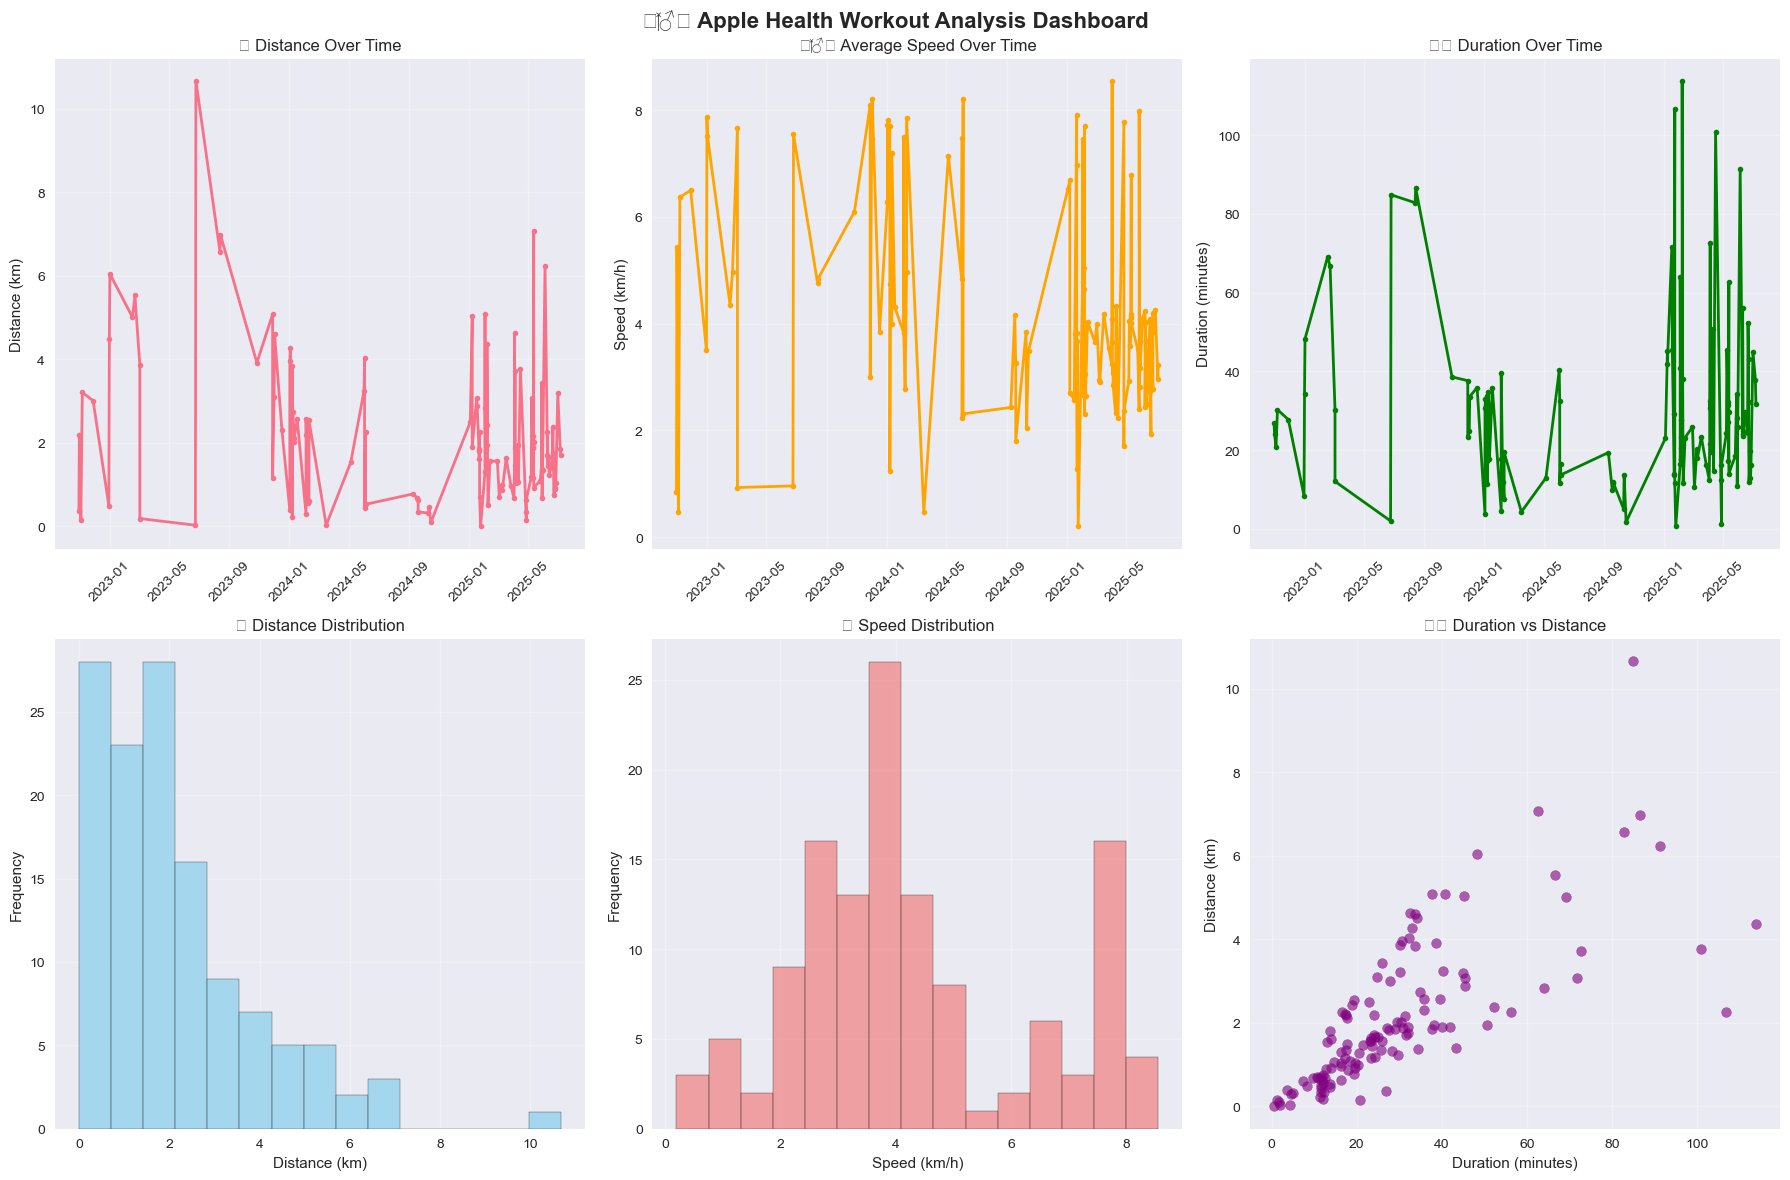

In [13]:
if not workout_df.empty:
    # Prepare data for plotting
    workout_df['date'] = pd.to_datetime(workout_df['date'])
    workout_df = workout_df.sort_values('date')
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🏃‍♂️ Apple Health Workout Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Distance over time
    axes[0,0].plot(workout_df['date'], workout_df['total_distance_km'], 
                   marker='o', linewidth=2, markersize=4)
    axes[0,0].set_title('📏 Distance Over Time')
    axes[0,0].set_ylabel('Distance (km)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Speed over time
    axes[0,1].plot(workout_df['date'], workout_df['avg_speed_kmh'], 
                   marker='o', color='orange', linewidth=2, markersize=4)
    axes[0,1].set_title('🏃‍♂️ Average Speed Over Time')
    axes[0,1].set_ylabel('Speed (km/h)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Duration over time
    axes[0,2].plot(workout_df['date'], workout_df['duration_minutes'], 
                   marker='o', color='green', linewidth=2, markersize=4)
    axes[0,2].set_title('⏱️ Duration Over Time')
    axes[0,2].set_ylabel('Duration (minutes)')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Distance distribution
    axes[1,0].hist(workout_df['total_distance_km'], bins=15, alpha=0.7, 
                   color='skyblue', edgecolor='black')
    axes[1,0].set_title('📊 Distance Distribution')
    axes[1,0].set_xlabel('Distance (km)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Speed distribution
    axes[1,1].hist(workout_df['avg_speed_kmh'], bins=15, alpha=0.7, 
                   color='lightcoral', edgecolor='black')
    axes[1,1].set_title('📊 Speed Distribution')
    axes[1,1].set_xlabel('Speed (km/h)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Duration vs Distance scatter
    axes[1,2].scatter(workout_df['duration_minutes'], workout_df['total_distance_km'], 
                      alpha=0.6, s=50, c='purple')
    axes[1,2].set_title('⏱️ Duration vs Distance')
    axes[1,2].set_xlabel('Duration (minutes)')
    axes[1,2].set_ylabel('Distance (km)')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [14]:
if not workout_df.empty:
    print("\n" + "="*60)
    print("🏆 BEST WORKOUTS")
    print("="*60)
    
    # Best distance workout
    best_distance = workout_df.loc[workout_df['total_distance_km'].idxmax()]
    print(f"🥇 Longest Distance Workout:")
    print(f"   📅 Date: {best_distance['date'].strftime('%Y-%m-%d')}")
    print(f"   📏 Distance: {best_distance['total_distance_km']} km")
    print(f"   ⏱️ Duration: {best_distance['duration_minutes']:.1f} minutes")
    print(f"   🏃‍♂️ Avg Speed: {best_distance['avg_speed_kmh']:.2f} km/h")
    
    # Fastest workout
    fastest_workout = workout_df.loc[workout_df['avg_speed_kmh'].idxmax()]
    print(f"\n🚀 Fastest Workout:")
    print(f"   📅 Date: {fastest_workout['date'].strftime('%Y-%m-%d')}")
    print(f"   🏃‍♂️ Speed: {fastest_workout['avg_speed_kmh']:.2f} km/h")
    print(f"   📏 Distance: {fastest_workout['total_distance_km']} km")
    print(f"   ⏱️ Duration: {fastest_workout['duration_minutes']:.1f} minutes")
    
    # Longest workout
    longest_workout = workout_df.loc[workout_df['duration_minutes'].idxmax()]
    print(f"\n⏰ Longest Duration Workout:")
    print(f"   📅 Date: {longest_workout['date'].strftime('%Y-%m-%d')}")
    print(f"   ⏱️ Duration: {longest_workout['duration_minutes']:.1f} minutes")
    print(f"   📏 Distance: {longest_workout['total_distance_km']} km")
    print(f"   🏃‍♂️ Avg Speed: {longest_workout['avg_speed_kmh']:.2f} km/h")


🏆 BEST WORKOUTS
🥇 Longest Distance Workout:
   📅 Date: 2023-06-25
   📏 Distance: 10.67 km
   ⏱️ Duration: 84.9 minutes
   🏃‍♂️ Avg Speed: 7.55 km/h

🚀 Fastest Workout:
   📅 Date: 2025-04-03
   🏃‍♂️ Speed: 8.55 km/h
   📏 Distance: 4.63 km
   ⏱️ Duration: 32.5 minutes

⏰ Longest Duration Workout:
   📅 Date: 2025-02-06
   ⏱️ Duration: 113.8 minutes
   📏 Distance: 4.36 km
   🏃‍♂️ Avg Speed: 2.30 km/h


In [15]:
if not workout_df.empty:
    # Save to CSV
    output_file = 'apple_health_workout_analysis.csv'
    workout_df.to_csv(output_file, index=False)
    print(f"\n💾 Data saved to: {output_file}")
    
    # Show file info
    print(f"📈 Total workouts analyzed: {len(workout_df)}")
    print(f"📁 Data columns: {', '.join(workout_df.columns)}")
    print("\n✅ Analysis complete! Check the CSV file for detailed data.")

print("\n🎉 GPX Analysis finished! You can now:")
print("   📊 View the charts above")
print("   📋 Check the CSV file for detailed data")
print("   🔄 Run individual cells to refresh analysis")
print("   📈 Use the data for further analysis")


💾 Data saved to: apple_health_workout_analysis.csv
📈 Total workouts analyzed: 127
📁 Data columns: total_distance_km, duration_minutes, avg_speed_kmh, elevation_gain_m, total_points, start_time, end_time, file_name, date

✅ Analysis complete! Check the CSV file for detailed data.

🎉 GPX Analysis finished! You can now:
   📊 View the charts above
   📋 Check the CSV file for detailed data
   🔄 Run individual cells to refresh analysis
   📈 Use the data for further analysis
